In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import log_loss, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
stroke = pd.read_csv("/content/stroke_data_new (1).csv")

In [ ]:
stroke

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,63.0,0,1,1,4,1,228.69,36.6,1,1
1,1.0,42.0,0,1,1,4,0,105.92,32.5,0,1
2,0.0,61.0,0,0,1,4,1,171.23,34.4,1,1
3,1.0,41.0,1,0,1,3,0,174.12,24.0,0,1
4,1.0,85.0,0,0,1,4,1,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
40905,1.0,38.0,0,0,0,4,1,120.94,29.7,1,0
40906,0.0,53.0,0,0,1,4,0,77.66,40.8,0,0
40907,1.0,32.0,0,0,1,2,0,231.95,33.2,0,0
40908,1.0,42.0,0,0,1,3,0,216.38,34.5,0,0


In [ ]:
stroke['stroke'].value_counts()

stroke
1    20460
0    20450
Name: count, dtype: int64

In [ ]:
stroke['work_type'].value_counts()

work_type
4    25570
3     9236
2     5588
1      431
0       85
Name: count, dtype: int64

In [ ]:
stroke['Residence_type'].value_counts()

Residence_type
1    21064
0    19846
Name: count, dtype: int64

In [ ]:
stroke['smoking_status'].value_counts()

smoking_status
0    20921
1    19989
Name: count, dtype: int64

In [ ]:
df = stroke.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


In [ ]:
df = df.dropna()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40907 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40907 non-null  float64
 2   hypertension       40907 non-null  int64  
 3   heart_disease      40907 non-null  int64  
 4   ever_married       40907 non-null  int64  
 5   work_type          40907 non-null  int64  
 6   Residence_type     40907 non-null  int64  
 7   avg_glucose_level  40907 non-null  float64
 8   bmi                40907 non-null  float64
 9   smoking_status     40907 non-null  int64  
 10  stroke             40907 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.7 MB


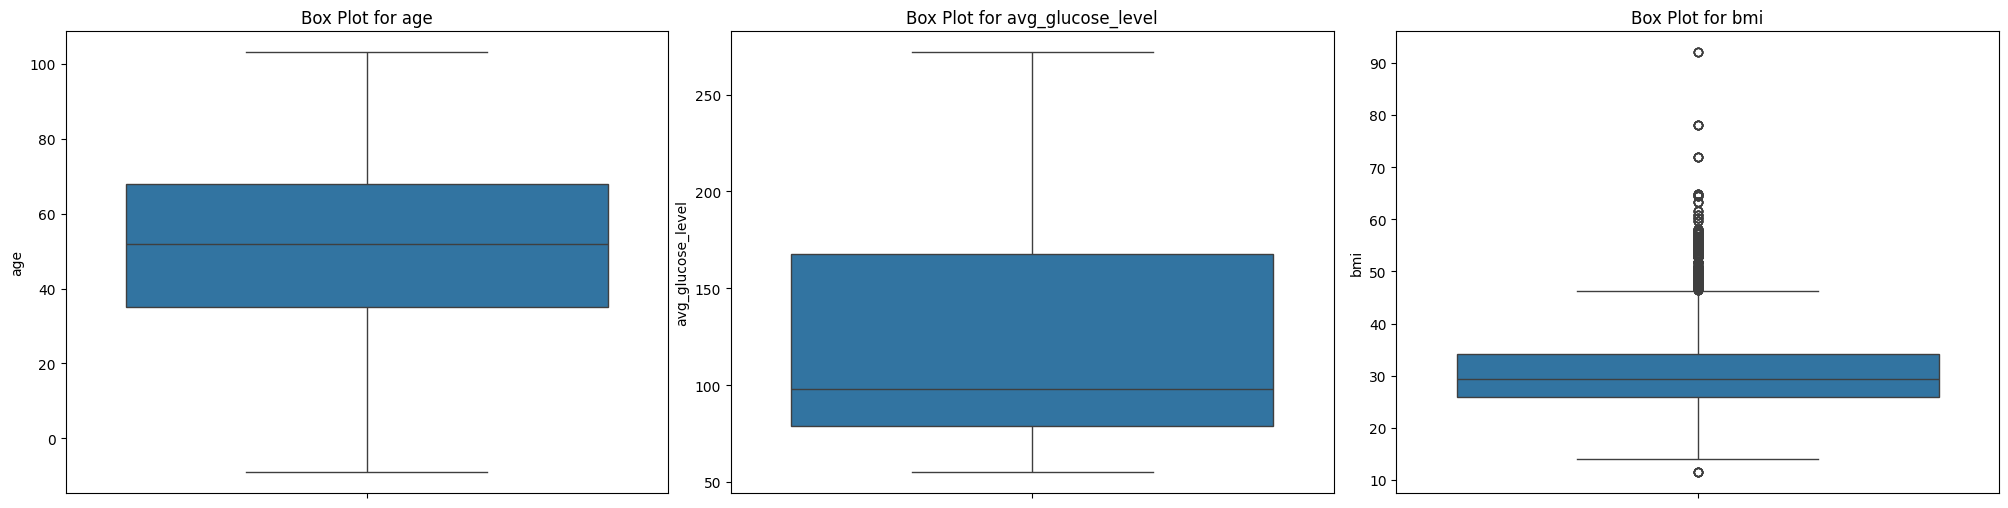

In [ ]:
#Identifikasi outlier
numeric_columns = ['age', 'avg_glucose_level', 'bmi']

fig, axs = plt.subplots(ncols=len(numeric_columns), figsize=(20, 5))

for i, column in enumerate(numeric_columns):
    sns.boxplot(y=column, data=df, ax=axs[i], whis=1.5)
    axs[i].set_title(f'Box Plot for {column}')
    axs[i].set_xlabel('')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

In [ ]:
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Menghapus outlier dari DataFrame
df_cleaned = remove_outliers(df, numeric_columns)

In [ ]:
df = df_cleaned.copy()

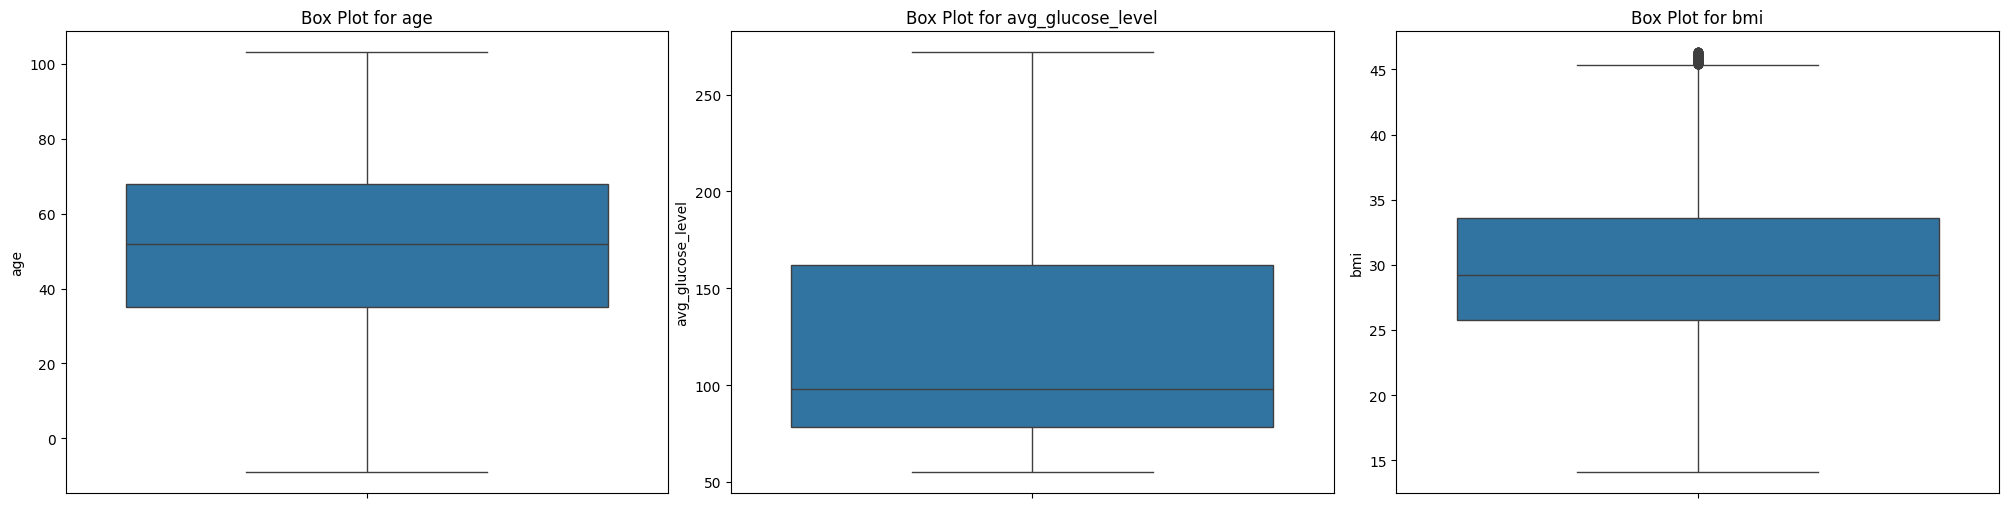

In [ ]:
# Pemeriksaan outlier
fig, axs = plt.subplots(ncols=len(numeric_columns), figsize=(20, 5))

for i, column in enumerate(numeric_columns):
    sns.boxplot(y=column, data=df, ax=axs[i], whis=1.5)
    axs[i].set_title(f'Box Plot for {column}')
    axs[i].set_xlabel('')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

In [ ]:
selected_features = df[['age','avg_glucose_level','bmi','hypertension', 'heart_disease','smoking_status','stroke']]

In [ ]:
selected_features.duplicated().sum()

6883

In [ ]:
df = selected_features.drop_duplicates()

In [ ]:
df

,age,avg_glucose_level,bmi,hypertension,heart_disease,smoking_status,stroke
0,63.0,228.69,36.6,0,1,1,1
1,42.0,105.92,32.5,0,1,0,1
2,61.0,171.23,34.4,0,0,1,1
3,41.0,174.12,24.0,1,0,0,1
4,85.0,186.21,29.0,0,0,1,1
...,...,...,...,...,...,...,...
40903,30.0,79.55,21.1,0,0,1,0
40905,38.0,120.94,29.7,0,0,1,0
40906,53.0,77.66,40.8,0,0,0,0
40908,42.0,216.38,34.5,0,0,0,0


In [ ]:
# Membagi data menjadi fitur (X) dan target (y)
X = df.drop(columns=['stroke'])
y = df['stroke']

In [ ]:
# Pemisahan data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45545)

In [ ]:
# Membuat model Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_dim= 6 ,activation = "relu"),
    tf.keras.layers.Dense(256,activation = "relu"),
    tf.keras.layers.Dense(128,activation = "relu"),
    tf.keras.layers.Dense(64,activation = "relu"),
    tf.keras.layers.Dense(32,activation = "relu"),
    tf.keras.layers.Dense(16,activation = "relu"),
    tf.keras.layers.Dense(8,activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(optimizer= Adam(learning_rate = 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data = (X_test, y_test))


Epoch 1/100
828/828 [==============================] - 8s 7ms/step - loss: 0.6480 - accuracy: 0.6396 - val_loss: 0.6087 - val_accuracy: 0.6834
Epoch 2/100
828/828 [==============================] - 8s 9ms/step - loss: 0.6137 - accuracy: 0.6780 - val_loss: 0.5949 - val_accuracy: 0.7055
Epoch 3/100
828/828 [==============================] - 6s 7ms/step - loss: 0.5971 - accuracy: 0.6996 - val_loss: 0.6041 - val_accuracy: 0.6855
Epoch 4/100
828/828 [==============================] - 7s 9ms/step - loss: 0.5941 - accuracy: 0.6994 - val_loss: 0.5886 - val_accuracy: 0.7109
Epoch 5/100
828/828 [==============================] - 6s 7ms/step - loss: 0.5919 - accuracy: 0.7013 - val_loss: 0.5814 - val_accuracy: 0.7108
Epoch 6/100
828/828 [==============================] - 8s 10ms/step - loss: 0.5893 - accuracy: 0.7030 - val_loss: 0.5847 - val_accuracy: 0.7115
Epoch 7/100
828/828 [==============================] - 6s 7ms/step - loss: 0.5850 - accuracy: 0.7082 - val_loss: 0.5754 - val_accuracy: 0.713

207/207 [==============================] - 2s 7ms/step - loss: 0.3397 - accuracy: 0.8345
Accuracy: 83.45%


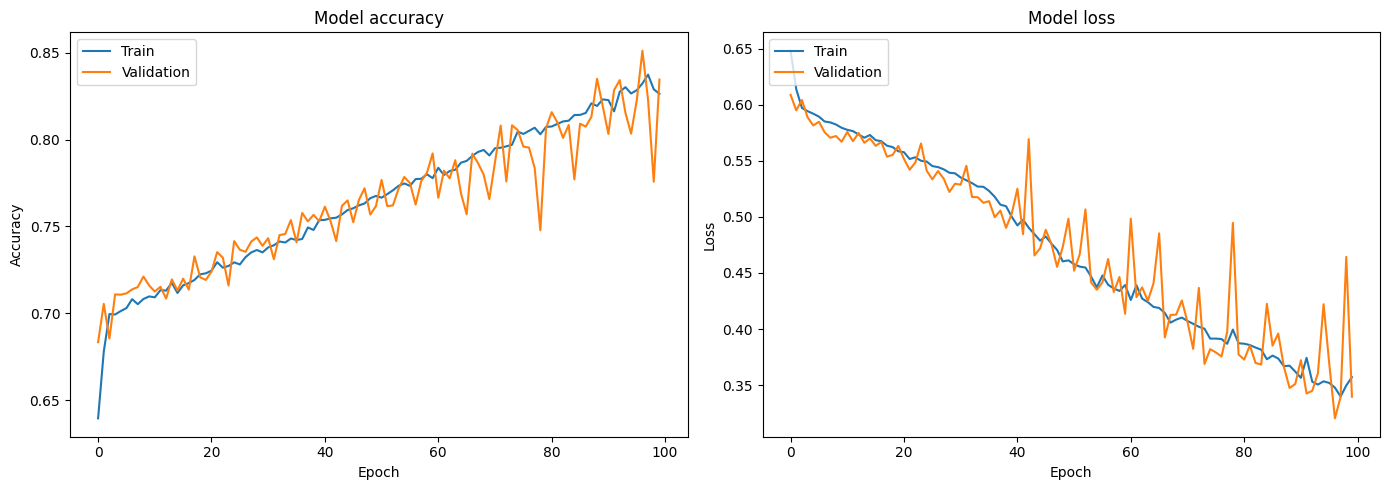

In [ ]:
# Evaluasi model pada data testing
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualisasi loss dan accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


207/207 [==============================] - 2s 8ms/step


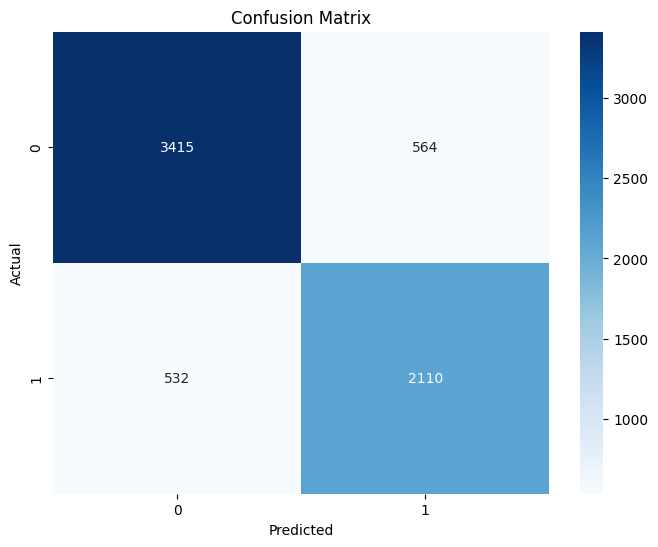

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3979
           1       0.79      0.80      0.79      2642

    accuracy                           0.83      6621
   macro avg       0.83      0.83      0.83      6621
weighted avg       0.83      0.83      0.83      6621



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Prediksi pada data testing
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes))

In [ ]:
y_test.value_counts()

stroke
0    3979
1    2642
Name: count, dtype: int64

In [ ]:
# Menyimpan model neural network
model.save("/content/STROKE tanpa norm.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/STROKE tanpa norm.h5")

In [ ]:
# Data dummy
data_dummy = {
    'age': [5],
    'avg_glucose_level': [0],
    'bmi': [0],
    'hypertension': [0],
    'heart_disease': [0],
    'smoking_status': [0]
}

# Buat DataFrame langsung dari data dummy
new_df = pd.DataFrame(data_dummy)

# Prediksi dengan model
predictions = model.predict(new_df)

# Output hasil prediksi
print("Prediksi probabilitas Stroke:", predictions)

# Konversi probabilitas menjadi kelas biner
predicted_classes = (predictions > 0.5).astype("int32")
print("Prediksi kelas Stroke (1: Ya, 0: Tidak):", predicted_classes)

1/1 [==============================] - 0s 115ms/step
Prediksi probabilitas Stroke: [[6.533577e-27]]
Prediksi kelas Stroke (1: Ya, 0: Tidak): [[0]]
